# Project Outline

## Project goals for IMU gait analysis:

* Determine heel strike events
* Determine heel off events
* Determine toe-off events
* Determine stride length

## Action Plan

* Learn what quaternions are
* Learn how to filter data
* Use filter to estimate orientation
* Use spikes in vertical acceleration to estimate heel-strike, heel-off, and toe-off events
* Use orientation and acceleration data to estimate position during swing phase
* Use ZUPT for stance phase
* Use position to calculate stride length

# Setup Python Modules

In [1]:
import math
import IPython
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, IntSlider

%matplotlib inline

# Representing Rotation

Here we explore two ways to represent rotation: matricies and quaternions.

## Rotation Matricies

Rotation matricies are the most straightforward way to represent rotations in 3d space. Here is a brief overview of how they can be used.

in 3d space, we can represent any point $P$ as a vector $\overrightarrow P$ from the origin like this, $$\overrightarrow P = \begin{bmatrix}x\\y\\z\end{bmatrix},$$
meaning that $P$ can be reached in the $x$-$y$-$z$ coordinate system by travling $x$ units along the $x$-axis, followed by $y$ units parallel to the $y$-axis, followed by $z$ units parallel to the $z$-axis. Another way of imagining this is using the three component vectors of the coordinate system,
$$\widehat{\mathbf i} = \begin{bmatrix}1\\0\\0\end{bmatrix}, \quad \widehat{\mathbf j} = \begin{bmatrix}0\\1\\0\end{bmatrix}, \quad \widehat{\mathbf k} = \begin{bmatrix}0\\0\\1\end{bmatrix},$$
which let us write $\overrightarrow P$ as the sum
$$\overrightarrow P = x\left(\widehat{\mathbf i}\right) + y\left(\widehat{\mathbf j}\right) + z\left(\widehat{\mathbf k}\right).$$
 If we apply a linear transformation to our coordinate system (such as a rotation) that sends $P$ to $P^\prime$, $\widehat{\mathbf i}$ to $\widehat{\mathbf i}^\prime$, $\widehat{\mathbf j}$ to $\widehat{\mathbf j}^\prime$, and $\widehat{\mathbf k}$ to $\widehat{\mathbf k}^\prime$, and that transformation is linear, then we will have
$$\overrightarrow{P^\prime} = x\left(\widehat{\mathbf i}^\prime\right) + y\left(\widehat{\mathbf j}^\prime\right) + z\left(\widehat{\mathbf k}^\prime\right).$$
In other words, we can represent any linear transformation in our coordinate system by where it sends our component vectors. In order to represent this information a little bit more succictly, we can put them together into something called a 'matrix', where  $\widehat{\mathbf i}^\prime$ is the first column,  $\widehat{\mathbf j}^\prime$ is the second column, and $\widehat{\mathbf k}^\prime$ is the third column. For example, a transformation that does not move our component vectors at all (and therefore leaves all points where they are) would be represented by
$$\begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}.$$
In fact, this do-nothing matrix is so important that we usually call it the '3x3 identity matrix'. More generally, any multiplication of a vector by a matrix can be represented as
$$\begin{bmatrix}a_1 & b_1 & c_1 \\ a_2 & b_2 & c_2 \\ a_3 & b_3 & c_3 \end{bmatrix}\begin{bmatrix}x\\y\\z\end{bmatrix} = \begin{bmatrix}xa_1 + yb_1 + zc_1 \\ xa_2 + yb_2 + zc_2 \\ xa_3 + yb_3 + zc_3\end{bmatrix}.$$
Similarlly, when multiplying two 3x3 matricies together the resulting matrix will have first column equal to the left matrix times the first column of the right one, etc....

 A basic 3d rotation (or elemental rotation) rotatetes an object around one of the three axes of the coordinate system. The rotation matricies to rotate vectors around the $x$, $y$, and $z$ axes respectively, are

\begin{align}
R_x(\theta) &= \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta & -\sin \theta \\
0 & \sin \theta & \cos \theta
\end{bmatrix} \\\\
R_y(\psi) &= \begin{bmatrix}
\cos \psi & 0 & \sin \psi \\
0 & 1 & 0 \\
-\sin \psi & 0 & \cos \psi
\end{bmatrix} \\\\
R_z(\phi) &= \begin{bmatrix}
\cos \phi & -\sin \phi & 0 \\
\sin \phi & \cos \phi & 0 \\
0 & 0 & 1
\end{bmatrix}.
\end{align}

Therefore, the combined rotation matrix that represents a rotation of $\theta$ about the $x$-axis, followed by $\psi$ about the $y$-axis, followed by $\phi$ aobut the $z$-axis is
\begin{align}
R &= R_z(\phi) R_y(\psi) R_x(\theta)  \\
&= \begin{bmatrix}\cos \phi & -\sin \phi & 0 \\
\sin \phi & \cos \phi & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \psi & 0 & \sin \psi \\
0 & 1 & 0 \\
-\sin \psi & 0 & \cos \psi
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta & -\sin \theta \\
0 & \sin \theta & \cos \theta
\end{bmatrix} \\\\
&= \begin{bmatrix}
\cos \phi & -\sin \phi & 0 \\
\sin \phi & \cos \phi & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos\psi & \sin\theta\sin\psi & \cos\theta\sin\psi \\
0 & \cos\theta & -\sin\theta \\
-\sin\psi & \sin\theta\cos\psi & \cos\theta\cos\psi
\end{bmatrix} \\\\
&= \begin{bmatrix}
\cos \psi\cos \phi & \sin\theta\sin\psi\cos\phi - \cos\theta\sin\phi & \cos\theta\sin\psi\cos\phi + \sin\theta\sin\phi \\
\cos\psi \sin\phi & \sin\theta\sin\psi\sin\phi + \cos\theta\cos\phi & \cos\theta\sin\psi\sin\phi - \sin\theta\cos\phi \\
-\sin\psi & \sin\theta\cos\psi & \cos \theta\cos \psi
\end{bmatrix}. \\
\end{align}
While this could in theory be

For a more in depth explanation of vectors and matricies, see 3Blue1Brown's [videos on linear algebra](https://www.3blue1brown.com/topics/linear-algebra), where I learned everything I've written above.

In [2]:
from math import sin, cos, pi

#set angles
theta = pi/3
phi = 0

#make a 2d vector & rotation matrix
vector2d = np.array([[1],[0]])
rotation_matrix = np.array(
    [[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

#rotate 2d vector counterclockwise by theta
def rotate2dvec(vec, theta):
    matrix = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return(np.dot(matrix, vec))

#make a 3d vector
vec3d = np.array([[cos(theta)], [sin(theta)*cos(phi)], [sin(phi)]])

#rotate vector by yaw A, ptich B, roll C
def rotate3dvec(vec, A, B, C):
    row1 = [cos(A)*cos(B), cos(A)*sin(B)*sin(C)-sin(A)*cos(C),
            cos(A)*sin(B)*cos(C)+sin(A)*sin(B)]
    row2 = [sin(A)*cos(B), sin(A)*sin(B)*sin(C)+cos(A)*cos(C),
            sin(A)*sin(B)*cos(C)-cos(A)*sin(C)]
    row3 = [-sin(B), cos(B)*sin(C), cos(B)*cos(C)]
    matrix = np.array([row1, row2, row3])
    return(np.dot(matrix, vec))

#rotate around x, y, z, axes
def rotateAxes(vector, x, y, z):
    vec = vector
    print(vec, '\n \n')
    r_x = np.array([[1, 0, 0], [0, cos(x), -sin(x)], [0, sin(x), cos(x)]])
    r_y = np.array([[cos(y), 0, sin(y)], [0, 1, 0], [-sin(y), 0, cos(y)]])
    r_z = np.array([[cos(z), -sin(z), 0], [sin(z), cos(z), 0], [0, 0, 1]])
    for i in [r_x, r_y, r_z]:
        vec = np.dot(i, vec)
        print(vec, '\n \n')


#convert spherical coordinates to cartesian coordinates
def sphere2cart():
    print('empty')

"""
DEFINE MAIN FUNCTION
"""
def main():

    rotateAxes(vec3d, pi, pi, pi/6)



## Quaternions

Quaternions are four-dimensional hypercomplex numbers which offer a powerful approach to orientation tracking because of their capacity for representing three-dimensional rotations. Specifically, a single unit quaternion can represent any 3d rotation without the common pitfalls of other rotation representations, such as gimbal lock. Moreover, quaternions allow for efficient and numerically stable calculations, especially beneficial in real-time tracking contexts like gait analysis. The quaternion-based approach simplifies the compounding of rotations by encapsulating complex rotational transformations in quaternion multiplication, reducing the risk of drift and improving accuracy in sensor fusion algorithms. This capability makes quaternions particularly well-suited for the recursive nature of state estimation models, where orientation data from consecutive IMU measurements need to be seamlessly integrated over time.

Quaternions also support interpolation methods such as spherical linear interpolation (SLERP), which preserves the shortest path of rotation and minimizes error, critical in applications like gait analysis where precise orientation tracking is needed. This combination of stability, efficiency, and the ability to handle continuous rotations makes quaternions an optimal choice for robust and reliable orientation tracking in IMU-based gait analysis.

Quaternions represent orientation through a four-dimensional structure that encodes three-dimensional rotation in a single unit quaternion, typically denoted $q = w + xi + yj + zk$, where $w$, $x$, $y$, and $z$ are real numbers and $i$, $j$, and $k$, are imaginary units. To represent a rotation, a quaternion should be normalized (i.e., has a unit magnitude), which ensures that it purely represents rotation without scaling effects. To represent an orientation, a quaternion is computed based on a rotation axis and angle: a rotation of $\theta$ around an axis defined by a unit vector $(x, y, z)$ is represented as $q = \cos(\theta/2) + (xi, yj, zk)\sin(\theta/2)$. When applied to a vector (using quaternion multiplcation), this quaternion rotates it by the specified angle around the given axis. Quaternion multiplication combines two rotations in sequence, making it useful for updating orientations. Given two quaternions $q_1 = w_1 + x_1i + y_1j + z_1k$ and $q_2 = w_2 + x_2i + y_2j + z_2k$, their product $q = q_1 \cdot q_2$ results in a new quaternion that represents the combined rotation of $q_1$ followed by $q_2$. The product $q = q_1 \otimes q_2$ is calculated using the formula:
\begin{align}
q=q_1 \otimes q_2=&\ \left(w_1w_2 - x_1x_2 - y_1y_2 - z_1z_2\right) \\
&+ \left(w_1x_2 + x_1w_2 + y_1z_2 - z_1y_2\right)i \\
&+ \left(w_1y_2 - x_1z_2 + y_1w_2 + z_1x_2\right)j \\
&+ \left(w_1z_2 + x_1y_2 - y_1x_2 + z_1w_2\right)k.
\end{align}

This non-commutative operation (order matters) allows quaternions to accurately represent compounded rotations, as each multiplication applies the rotation of one quaternion to the orientation described by another, creating a seamless update for tracking.

Here is how we would use quaternions to represent rotation of a point $P$ by an angle of $\theta$ around an axis $A$ which passes through the origin. First, we normalize the vector $A$ such that if it has components $x$, $y$, $z$, then $x^2+y^2+z^2=1$. Next, we construct a quaternion $q$ such that
$$q = (\cos(\theta/2)+\sin(\theta/2)(xi+yj+zk)),$$
and its inverse $q^{-1}$ such that
$$q^{-1} = (\cos(\theta/2)-\sin(\theta/2)(xi+yj+zk)).$$
Now, we make a quaternion for our point $P$ so that if our point $P$ had coordinates $a$, $b$, $c$, then our quaternion $p$ is defined by
$$p = ai+bj+ck.$$
Now, to find the projection $P^\prime$ after the rotation, we have
$$P^\prime = q\otimes p\otimes q^{-1}.$$

This framework for how quaternions work is admittedly quite non-intuitive. However, if a more in depth explanation of the mechanics is desired, it can be found in CGP Grey's videos "[Visualizing quaternions (4d numbers) with stereographic projection](https://www.youtube.com/watch?v=d4EgbgTm0Bg)" and "[Visualizing quaternions (4d numbers) with stereographic projection](https://www.youtube.com/watch?v=zjMuIxRvygQ)", as well as his "[Visualizing Quaternions](https://eater.net/quaternions)" webpage with Ben Eater. For the rest of this notebook, these rules will continue to be used without further explanation.

### Building a ```quaternion_multiply``` function

In [3]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

This code multiplies two quaternions ```q1``` and ```q2``` and returns the resulting quaternion as a numpy array.

### Building a ```rotate_quaternion``` function

In [4]:
def rotate_quaternion(point, axis, angle: float) -> list:
    normalizedaxis = axis/np.linalg.norm(axis)
    q_inv = [math.cos(angle/2)]
    q = [math.cos(angle/2)]
    for value in normalizedaxis:
        q.append(math.sin(angle/2)*value)
        q_inv.append(-math.sin(angle/2)*value)
    pointquat = [0, point[0], point[1], point[2]]
    rotation = quaternion_multiply(quaternion_multiply(q, pointquat), q_inv)
    result = [float(i) for i in rotation[1:]]
    return(result)


Using ```quaternion_multiply```, this code represents rotations using quaternions. We can test this by checking that known rotations produce the correct result.

In [5]:
print(rotate_quaternion([1, 0, 0], [0, 1, 0], np.pi/2))

[2.220446049250313e-16, 0.0, -1.0]


### Visualization Example

Here are example visualizations we could build using ```quaternion_multiply``` and ```rotate_quaternion```.

#### Plotly Setup

To plot in an interactive, java-script based window, we can use plotly.

In [6]:
def plot_rotation_plotly(point, axis, angle, figure, label):
    t = np.linspace(0.0, angle, 100)
    x = np.zeros(100)
    y = np.zeros(100)
    z = np.zeros(100)
    for i in range(100):
        p = rotate_quaternion(point, axis, t[i])
        x[i] = p[0]
        y[i] = p[1]
        z[i] = p[2]
    figure.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines',
        name=label))
    figure.add_trace(go.Scatter3d(
        x=[0, axis[0]], y=[0, axis[1]], z=[0, axis[2]],
        mode='lines',
        name='Axis',
        # line=dict(color='pink', width=5)
        ))
    figure.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z[0]],
        mode='markers',
        name='Start',
        # line=dict(color='pink', width=5)
        ))
    figure.add_trace(go.Scatter3d(
        x=[x[-1]], y=[y[-1]], z=[z[-1]],
        mode='markers',
        name='End',
        # line=dict(color='pink', width=5)
        ))
    return rotate_quaternion(point, axis, angle)

def make3dplotly(name: str):
    fig = go.Figure()
    fig.update_layout(width=600, height=600, scene=dict(
        aspectmode = 'cube',
        xaxis=dict(nticks=4, range=[-1.2, 1.2]),
        yaxis=dict(nticks=4, range=[-1.2, 1.2]),
        zaxis=dict(nticks=4, range=[-1.2, 1.2]),
        bgcolor="white"),
        title=name, paper_bgcolor='lightgrey')

    fig.add_trace(go.Scatter3d(
        x=[-1.2, 1.2], y=[0, 0], z=[0, 0],
        mode='lines',
        name='x-axis',
        line=dict(color='black', width=5)
    ))

    fig.add_trace(go.Scatter3d(
        y=[-1.2, 1.2], x=[0, 0], z=[0, 0],
        mode='lines',
        name='y-axis',
        line=dict(color='black', width=5)
    ))

    fig.add_trace(go.Scatter3d(
        z=[-1.2, 1.2], y=[0, 0], x=[0, 0],
        mode='lines',
        name='z-axis',
        line=dict(color='black', width=5)
    ))
    return fig

Edit the lines
> ```
p = (1.,0.,0.)
ax = (.05, .1, .5)
ang = 3.29

with your own values to visualize a different point, axis, or angle.

*Note: the axes will not resize if you choose values that are too large to be in frame. If you would like to change this, you must modify lines 39-41 in the previous cell 'Plotly Setup'*.

In [7]:
p = (1.,0.,0.)
ax = (.05, .3, .5)
ang = 3.29

myfig = make3dplotly(
f'Rotation of ({p[0]}, {p[1]}, {p[2]}) by {ang} radians around \
({ax[0]}, {ax[1]}, {ax[2]})'
)
final_point = plot_rotation_plotly(p, ax, ang, myfig, 'rotation')
display(myfig)

#### Widgets Setup



To add interactivity to a plot using IPython, we can use widgets.

In [8]:
def plot_rotation_mpl(point, axis, angle, figure, name):
    t = np.linspace(0.0, angle, 100)
    x = np.zeros(100)
    y = np.zeros(100)
    z = np.zeros(100)
    for i in range(100):
        p = rotate_quaternion(point, axis, t[i])
        x[i] = p[0]
        y[i] = p[1]
        z[i] = p[2]
    figure.plot(x, y, z, label=name)
    ax_x = np.array([0, axis[0]])
    ax_y = np.array([0, axis[1]])
    ax_z = np.array([0, axis[2]])
    figure.plot(ax_x, ax_y, ax_z, label='Axis')
    return(rotate_quaternion(point, axis, angle))

def make3dfigure():
    figure = plt.figure().add_subplot(projection='3d')
    figure.set_xlabel('x')
    figure.set_ylabel('y')
    figure.set_zlabel('z')
    return figure

def plot3axes(figure):
    figure.plot((-1.3,1.3), (0,0), (0,0), label='x')
    figure.plot((0,0), (-1.3,1.3), (0,0), label='y')
    figure.plot((0,0), (0,0), (-1.3,1.3), label='z')

def plot_widget_rotation(px, py, pz, axx, axy, axz, angle, elevation, azimuth):
    my_widget_fig = make3dfigure()
    my_widget_fig.view_init(elevation,azimuth)
    plot3axes(my_widget_fig)
    plot_rotation_mpl([px, py, pz], [axx, axy, axz], angle, my_widget_fig, 'path')
    plt.legend()
    plt.show()

def get_rotation_widgets():
    angle_slider = FloatSlider(
        value=ang, min=0., max=2*math.pi, step=0.1, description="Angle")
    axx_slider = FloatSlider(
        value=ax[0], min=0., max=1.0, step=0.1, description="Axis x")
    axy_slider = FloatSlider(
        value=ax[1], min=0., max=1.0, step=0.1, description="Axis y")
    axz_slider = FloatSlider(
        value=ax[2], min=0., max=1.0, step=0.1, description="Axis z")
    px_slider = FloatSlider(
        value=p[0], min=-1., max=1.0, step=0.1, description="Point x")
    py_slider = FloatSlider(
        value=p[1], min=-1., max=1.0, step=0.1, description="Point y")
    pz_slider = FloatSlider(
        value=p[2], min=-1., max=1.0, step=0.1, description="Point z")
    elevation_slider= IntSlider(
        value=35, min=-90, max=90,step=5, continuous_update=False)
    azimuth_slider= IntSlider(
        value=45, min=0, max=360,step=5, continuous_update=False)
    return [px_slider, py_slider, pz_slider, axx_slider, axy_slider, axz_slider, angle_slider, elevation_slider, azimuth_slider]

Now we can visualize rotations using MatPlotLib and widgets:

In [9]:
(px_slider, py_slider, pz_slider, axx_slider, axy_slider, axz_slider,
 angle_slider, elevation_slider, azimuth_slider) = get_rotation_widgets()

interact(plot_widget_rotation, px=px_slider, py=py_slider, pz=pz_slider,
    axx=axx_slider, axy=axy_slider, axz=axz_slider, angle=angle_slider,
    elevation=elevation_slider, azimuth=azimuth_slider);

interactive(children=(FloatSlider(value=1.0, description='Point x', max=1.0, min=-1.0), FloatSlider(value=0.0,…

These quaterions will come back when storing orientation data for the IMUs, but first, filtering the data will be addressed.

# Filters

Here, we will address filtering. We will begin with the g-h (aka the $\alpha$-$\beta$) filter and build our way up to the Kalman Filter.

#### Install ```filterpy```

In [ ]:
!pip install filterpy
import filterpy.kalman as kf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=4a02049cb6911dcab64714dece46d89a0a9c508377b07814ae222a6bbce504d8
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


## The g-h Filter

The g-h filter is a recursive algorithm used to estimate the state of dynamic systems from noisy measurements. One of its applications is tracking the position and velocity of objects. The g-h filter helps smooth out this noisy data by using two parameters, g (alpha) and h (beta), to adjust the level of filtering applied to the position and velocity estimates. By dynamically adjusting these parameters, the filter can be tuned to respond more or less aggressively to changes in the measured data, providing a balance between the system's predictions and real-time observations. This makes it particularly useful for systems where the state changes gradually over time. The g-h filter's simplicity and computational efficiency make it suitable for real-time applications, where computational resources may be limited. It offers a practical solution for integrating noisy sensor data with a predictive model to produce optimal state estimates, much like the Kalman Filter, but with fewer computational demands. Interestingly, the Kalman Filter can be viewed as an advanced version of the g-h filter, employing more sophisticated methods to dynamically update the g and h parameters. Starting with the g-h filter is an excellent entry point for building up to the more complex Kalman Filter, as it lays the foundational understanding of recursive filtering and state estimation. The following code performs a g-h filter on 1 state variable with a fixed g and h.

### g-h in Python

In [ ]:
def g_h_filter(data, x0, dx, g, h, dt):
    estimates = []
    x = x0
    for z in data:
        #prediction step
        xp = x + (dx * dt)

        #update step
        residual = z - xp
        dx += h * (residual / dt)
        x = xp + (g * residual)
        estimates.append(x)
    return np.array(estimates)

### The logic behind ```g_h_filter```

The arguments passed to the function are:
* ```data``` contains the data to be filtered.
* ```x0``` is the initial value for our state variable.
* ```dx``` is the initial change rate for our state variable.
* ```g``` is the g-h's g scale factor.
* ```h``` is the g-h's h scale factor.
* ```dt``` is the length of the time step.

The function then uses the following logic:
* Create a list to hold the ```estimates``` and set the initial estimate with ```x = x0```
* Iterate through the ```data``` and filter

    * Predict the state with ```xp = x + (dx * dt)```. Here, ```x``` is the last extimate and ```(dx * dt)``` is the (rate-of-change × time-step).

    * Calculate the ```residual``` as the difference of measurement (```z```) and predicted state (```xp```).

    * Update the rate-of-change (```dx```) by adding ```h * (residual / dt)```. The purpose of this is to weight the new information on rate-of-change with a factor of $h$, and our previous information with a factor of $(1-h)$. To see why this is the correct adjustment to ```dx```, note that this is equivalent to \begin{aligned}\text{new dx} &= \text{old dx} + h\left(\frac{\text{residual}}{\text{dt}}\right)\\ &= \text{old dx} + h\left(\frac{\text{z - xp}}{\text{dt}}\right)\\ &= \text{old dx} + h\left(\frac{\text{z - (x + (old dx} * \text{dt))}}{\text{dt}}\right)\\ &= \text{old dx} + h\left(\frac{\text{z - x}}{\text{dt}} - \text{old dx}\right)\\ &= \text{old dx}(1-h) + h\left(\frac{\text{z - x}}{\text{dt}}\right).\end{aligned} Thus, ```dx``` is correctly adjusted by weighting the the $\text{dx}$ suggested by the measurement with a factor of $h$, and weighting the old $\text{dx}$ with a factor of $(1-h)$.

    * Update the state of with ```x = xp + (g * residual)```. Similarly, the purpose of this is to weight the new information on the state with a factor of $g$, and our previous information with a factor of $(1-g)$. To see that this is the correct expression for ```x```, note that this is equivalent to \begin{aligned}\text{x} &= \text{xp} + (g * \text{residual})\\ &= \text{xp} + g * \text{(z - xp)}\\ &= \text{xp}(1-g) + g(\text{z}),\end{aligned} as desired.

    * Append the estimate ```x``` to the list of estimates
* Return the list ```estimates``` as a numpy array.

This g-h filter logic is the same general framework that a kalman filter uses, though the kalman is a bit more complex than the simple g-h.

## The Kalman Filter

The Kalman Filter is a recursive algorithm used to estimate the state of dynamic systems from noisy measurements. One of its application is tracking the orientation of an Inertial Measurement Unit (IMU). IMUs provide data on acceleration and angular velocity but are prone to noise and drift over time. The Kalman Filter helps fuse this noisy sensor data with a predictive model to more accurately estimate the IMU's orientation given the measurement errors. In general, the Kalman Filter's ability to combine system predictions with real-time observations to produce optimal state estimates makes it useful in dynamic systems where the state changes over time. It is also computationally efficient due to its recursive nature, making it suitable for real-time applications.

### Kalman Equations for Linear Systems

The simple kalman filter estimates an nx1 column vector state variable \(x_k\), based on some mx1 column vector measurement \(z_k\), using a system model:
\begin{align*}
\text{state transition matrix} &: A  &(& \text{nxn matrix}), \\
\text{process noise covariance} &: Q  &(& \text{nxn diagonal matrix}), \\
\text{measurement covariance} &: R  &(& \text{mxm matrix}). \\
\text{measurement model matrix} &: H  &(& \text{mxn matrix}), \\
\end{align*}

After the system model has been set, there are five steps of the simple kalman filter: \\

0. Set initial values
\begin{align*}
\widehat{x}_0 &= \text{initial state} &(& \text{nx1 column vector}), \\
P_0 &= \text{initial error covariance} &(& \text{nxn matrix}).
\end{align*}

1. Predict state and error covariance:
\begin{align*}
\widehat{x}^-_k &= A\widehat{x}_{k-1}, \\
P^-_K &= AP_{k-1}A^t+Q.
\end{align*}

2. Compute kalman gain:
$$K_k = P^-_kH^T(HP^-_kH^T+R)^{-1}.$$

3. Compute the estimate (state update equation):
$$\widehat{x}_k = \widehat{x}^-_k+K_k (z_k-H\widehat{x}^-_k).$$

4. Compute the error covariance:
$$P_K = P^-_k-K_kHP^-_k.$$

Steps 1-4 are then repeated to recursively update with each new $z_k$.

*Notes:*
1. *Here, the minus-sign superscripts denote predicted values before measurement*

2. *The term $(z_k-H\widehat{x}^-_k)$ in the state update equation is important, because it represents the gap between our prediction, and our measurement. Because of this importance, it is given the name "measurement residual" or "innovation"*

This can be applied to both uni-variate or multi-variate systems, and the notation is unfortunates not always consistent. Below is an explanation from Roger Labbe in his book [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) (note that Labbe refers to the state transition as $\mathbf F$ rather than $\mathbf A$, uses the overbar rather than the "-" superscript, and does not use hat notation):

>"[the univariate and multivariate equations]... are quite similar.
>
><u>**Predict**</u>
>
>$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$
>
>Without worrying about the specifics of the linear algebra, we can see that:
$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.
$\mathbf F$ is the *state transition function*. When multiplied by $\bf x$ it computes the prior.
$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$.
$\mathbf B$ and $\mathbf u$ are new to us. They let us model control inputs to the system.
>
><u>**Update**</u>
>
>$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$
>
>$\mathbf H$ is the measurement function. We haven't seen this yet in this book and I'll explain it later. If you mentally remove $\mathbf H$ from the equations, you should be able to see these equations are similar as well.
$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter (I've substituted $\mu$ with $x$ for the univariate equations to make the notation as similar as possible).
$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain.
The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same:
-  Use a Gaussian to represent our estimate of the state and error
-  Use a Gaussian to represent the measurement and its error
-  Use a Gaussian to represent the process model
-  Use the process model to predict the next state (the prior)
-  Form an estimate part way between the measurement and the prior
>
>Your job as a designer will be to design the state $\left(\mathbf x, \mathbf P\right)$, the process $\left(\mathbf F, \mathbf Q\right)$, the measurement $\left(\mathbf z, \mathbf R\right)$, and the  measurement function $\mathbf H$. If the system has control inputs, such as a robot, you will also design $\mathbf B$ and $\mathbf u$."

To get the hang of this, lets try applying it to a simplified system before we tackle the whole problem of the IMU.

### Estimating Position from Velocity (Linear Example)

Suppose we have a sensor which gives us measurements of its velocity along the global axes in the form
$$z = [v_x, v_y, v_z]^T,$$
and we want to estimate its position along these world axes using a state variable of the form
$$x = [p_x, p_y, p_z, v_x, v_y, v_z]^T.$$

#### A - State Transition (Linear)

Here, to build our state transition matrix $\mathbf A$ (which Labbe calls $\mathbf F$), we want a matrix which satisfies
$$\widehat x^-_k = \mathbf A\cdot\widehat x_{k-1}.$$
Since $\widehat x^-_k$ is 6-dimensional, $\mathbf A$ will be a 6x6 matrix. If we don't expect the velocity to change much, then we probably want to use
$$\begin{bmatrix}
1 & 0 & 0 & \Delta t & 0 & 0\\
0 & 1 & 0 & 0 & \Delta t & 0\\
0 & 0 & 1 & 0 & 0 & \Delta t\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
p_x\\
p_y\\
p_z\\
v_x\\
v_y\\
v_z\end{bmatrix}$$
in order to update the positions based on our velocity information, so the matrix on the left can be $\mathbf A$.

#### Q - Proccess (Linear)

The process noise covariance matrix Q represents the uncertainties in the system dynamics. For our state vector, a reasonable choice for Q would be:
$$Q = \begin{bmatrix}
\sigma_p^2 & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_p^2 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_p^2 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_v^2 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_v^2 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_v^2
\end{bmatrix},$$
Where: $\sigma_p^2$ is the variance in the position components, and $\sigma_v^2$ is the variance in the velocity components. The specific values for these variances would depend on the characteristics of the system and the expected process noise.

#### R - Measurement Covariance (Linear)

The measurement covariance matrix R represents the uncertainties in our velocity measurements. Since our measurement vector z = [vx, vy, vz] is 3-dimensional, R would be a 3x3 matrix:
$$R = \begin{bmatrix}
\sigma_{vx}^2 & 0 & 0\\\\
0 & \sigma_{vy}^2 & 0\\\\
0 & 0 & \sigma_{vz}^2
\end{bmatrix}$$
Where $\sigma_{vx}^2$ is the variance in x-velocity measurements, $\sigma_{vy}^2$ is the variance in y-velocity measurements, and $\sigma_{vz}^2$ is the variance in z-velocity measurements. If the sensor has similar noise characteristics in all directions, all these values could be set equal, like:
$$R = \begin{bmatrix}
\sigma_v^2 & 0 & 0\\\\
0 & \sigma_v^2 & 0\\\\
0 & 0 & \sigma_v^2
\end{bmatrix}$$
The value of $\sigma_v^2$ would typically come from your sensor's specifications or from experimental characterization of the sensor's noise. For the sake of simplicity, let's use the second option for this example, where all axes have the same variance.


#### H - Measurment Function (Linear)

We want to be able to calculate the residual $y$ using
$$y = z_k-H\widehat{x}^-_k,$$
and since $z$ and $x$ are 3 and 6 dimensional, respectively, we are looking for a 3x6 matrix. Since we have a linear relationship between our state x=[px,py,pz,vx,vy,vz] and measurements.
H would be:
$$H = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}.$$
This H matrix simply "picks out" the velocity components from our state vector to relate them to our velocity measurements.

#### Putting it All Together (Linear)

So to recap, we have:
\begin{align}
z &= [v_x, v_y, v_z]^T,\\
x &= [p_x, p_y, p_z, v_x, v_y, v_z]^T,\\
\mathbf A &= \begin{bmatrix}
1 & 0 & 0 & \Delta t & 0 & 0\\
0 & 1 & 0 & 0 & \Delta t & 0\\
0 & 0 & 1 & 0 & 0 & \Delta t\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix},\\
Q &= \begin{bmatrix}
\sigma_p^2 & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_p^2 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_p^2 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_v^2 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_v^2 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_v^2
\end{bmatrix},\\
R &= \begin{bmatrix}
\sigma_v^2 & 0 & 0\\\\
0 & \sigma_v^2 & 0\\\\
0 & 0 & \sigma_v^2
\end{bmatrix},\\
H &= \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}.
\end{align}

Now, we must choose our initial values for the initial state $\widehat{x}_0$ (6x1 column vector), as well as our initial error covariance $P_0$ (6x6 matrix).

A reasonable $P_0$ would be:
$$P_0 = \begin{bmatrix}
\sigma_{p0}^2 & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_{p0}^2 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_{p0}^2 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_{v0}^2 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_{v0}^2 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_{v0}^2
\end{bmatrix}.$$
The values should reflect:
- $\sigma_{p0}^2$: Initial position uncertainty (could be several meters squared if GPS-like, or smaller if more precise initialization)
- $\sigma_{v0}^2$: Initial velocity uncertainty (could be a few meters/second squared)

Practical tips for choosing values:
- If you have no idea about initial position, use large values (e.g., 100² m²)
- If you know starting position precisely, use small values (e.g., 0.1² m²)
- For velocity, if starting from rest, you might use small values (e.g., 0.1² (m/s)²)
- Better to overestimate than underestimate - the filter will converge if P_0 is too large, but might not if it's too small

As for $\widehat{x}_0$, we may choose
$$\widehat{x}_0 = [0,0,0,0,0,0]^T$$
if we think the sensor will be stationary to begin with, and we aren't compelled to place the origin elsewhere.

Lets put this into code.

#### Putting it into Code (Linear)

In [ ]:
dataset_test = np.array([np.array([0., 0., 0.]).reshape(-1,1),
                         np.array([.5, 0., 0.]).reshape(-1,1),
                         np.array([1., 0., 0.]).reshape(-1,1)])
for i in dataset_test:
    print(i)

[[0.]
 [0.]
 [0.]]
[[0.5]
 [0. ]
 [0. ]]
[[1.]
 [0.]
 [0.]]


In [ ]:
def kf_pos_vel(px_0=0., py_0=0., pz_0=0., vx_0=0., vy_0=0., vz_0=0., pvar=10.,
               vvar=1., dt=.5, dataset=np.array(
                        [np.array([0., 0., 0.]).reshape(-1,1),
                         np.array([.5, 0., 0.]).reshape(-1,1),
                         np.array([1., 0., 0.]).reshape(-1,1),
                         np.array([1.5, 0.,0.]).reshape(-1,1)])):
    xp = np.array([px_0, py_0, pz_0, vx_0, vy_0, vz_0]).reshape(-1,1)

    Pp = np.zeros((6,6))
    Pp[0:3,0:3] = np.eye(3) * pvar
    Pp[3:6,3:6] = np.eye(3) * vvar

    A = np.eye(6)
    A[0:3,3:6] = np.eye(3) * dt
    At = np.transpose(A)

    Q = np.zeros((6,6))
    Q[0:3,0:3] = np.eye(3) * pvar
    Q[3:6,3:6] = np.eye(3) * vvar

    R = np.eye(3) * vvar

    H = np.zeros((3,6))
    H[0:3,3:6] = np.eye(3)
    Ht = np.transpose(H)

    filtered_data = []

    for z in dataset:
        # Compute Kalman Gain
        K = Pp @ Ht @ np.linalg.inv(H @ Pp @ Ht + R)
        # Compute State Update
        x = xp + K @ (z - H @ xp)
        filtered_data.append(x)
        # Compute Error Covariance
        P = (np.eye(6) - K @ H) @ Pp
        # Predict State
        xp = A @ xp
        Pp = A @ Pp @ At + Q
    return np.array(filtered_data)


kf_pos_vel()

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.08333333],
        [0.        ],
        [0.        ],
        [0.33333333],
        [0.        ],
        [0.        ]],

       [[0.375     ],
        [0.        ],
        [0.        ],
        [0.75      ],
        [0.        ],
        [0.        ]],

       [[0.9       ],
        [0.        ],
        [0.        ],
        [1.2       ],
        [0.        ],
        [0.        ]]])

### Estimating Velocity & Position from Acceleration (Non-Linear Example)

(THIS SECTION HAS NOT BEEN UPDATED)

Now, suppose we have a sensor which gives us measurements of its acceleration (NOT velocity) along the global axes in the form
$$z_k = [ax_k, ay_k, az_k]^T,$$
and we want to estimate its position and velocity along these world axes using a state variable of the form
$$\widehat x_k = [px_k, py_k, pz_k, vx_k, vy_k, vz_k]^T.$$
We could extend our state to a 9x1 vector and include acceleration, but there is another way aswell. Since acceleration does not have a linear relationship to position and instead has second derivative relationship, we will adjust our equations to account for this non-linearity.


#### A - State Transition (Non-Linear)

The following state transtion function $f(x)$ propogates (or "evolves") the state forward in time:
$$f(\widehat x_k) =
\begin{bmatrix}
px_k + vx_k \cdot dt\\
py_k + vy_k \cdot dt\\
pz_k + vz_k \cdot dt\\
vx_k\\
vy_k\\
vz_k
\end{bmatrix}$$
In this case, taking the jacobian of this matrix actually ends up giving us the same matrix
$$\mathbf A =
\begin{bmatrix}
1 & 0 & 0 & \Delta t & 0 & 0\\
0 & 1 & 0 & 0 & \Delta t & 0\\
0 & 0 & 1 & 0 & 0 & \Delta t\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}.$$

#### Q - Proccess (Non-Linear)

The process noise covariance matrix Q represents the uncertainties in the system dynamics. For our state vector, a reasonable choice for Q would be:
$$Q = \begin{bmatrix}
\sigma_p^2 & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_p^2 & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_p^2 & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_v^2 & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_v^2 & 0\\
0 & 0 & 0 & 0 & 0 & \sigma_v^2
\end{bmatrix},$$
Where: $\sigma_p^2$ is the variance in the position components, and $\sigma_v^2$ is the variance in the velocity components. The specific values for these variances would depend on the characteristics of the system and the expected process noise.

#### R - Measurement Covariance (Non-Linear)

The measurement covariance matrix R represents the uncertainties in our acceleration measurements. Since our measurement vector z = [ax, ay, az] is 3-dimensional, R would be a 3x3 matrix:
$$R = \begin{bmatrix}
\sigma_{ax}^2 & 0 & 0\\\\
0 & \sigma_{ay}^2 & 0\\\\
0 & 0 & \sigma_{az}^2
\end{bmatrix}$$
Where $\sigma_{ax}^2$ is the variance in x-acceleration measurements, $\sigma_{ay}^2$ is the variance in y-acceleration measurements, and $\sigma_{az}^2$ is the variance in z-acceleration measurements. If the accelerometer has similar noise characteristics in all directions, all these values could be set equal, like:
$$R = \begin{bmatrix}
\sigma_a^2 & 0 & 0\\\\
0 & \sigma_a^2 & 0\\\\
0 & 0 & \sigma_a^2
\end{bmatrix}$$
The value of $\sigma_a^2$ would typically come from your sensor's specifications or from experimental characterization of the sensor's noise.


#### H - Measurement Function (Non-Linear)

the measurement function $h(x)$ relates the state variables (positions and velocities) to the acceleration measurements:
$$h(\widehat x_k^-) =
\begin{bmatrix}
vx^2 + vy^2 + vz^2\\
0\\
0
\end{bmatrix}.$$

## **Applying this to IMU Data**

Let's explore the math here in the context of IMU data. In our state vector, we would like to keep track of the
- position,
- velocity,
- accelaration (optional),
- orientation,
- rotational velocity.

If we represent position, velocity, acceleration, and rotational velocity  with respect to the global $x$-$y$-$z$-axes, and we represent orientation using quaternions, then we will be working with a state variable of the form
$$\mathbf x_k = [px_k, py_k, pz_k, vx_k, vy_k, vz_k, ax_k, ay_k, az_k, q0_k, q1_k, q2_k, q3_k, \omega x_k, \omega y_k, \omega z_k]^T.$$
Since the sensor will make measurement relative to the local pitch-roll-yaw-axes, we will have measurements of the form $$\mathbf z_k = \left[a_{pitch}, a_{roll}, a_{yaw}, \omega_{pitch}, \omega_{roll}, \omega_{yaw}\right]^T.$$
Since our measurements will use a different coordinate system than our state variable, we will probably want to have some internal computation that lets us convert between local and world axes. One way to do this would be to stick to our quaternion guns, but due to numpy's optimization of linear algebra, this matrix can be more efficient:
$$\mathbf R_k = \begin{bmatrix}
1 - 2[(q2_k)^2 + (q3_k)^2] & 2[q_1 (q2_k) - (q0_k) (q3_k)] & 2[(q1_k) (q3_k) + (q0_k) (q2_k)] \\
2[(q1_k) (q2_k) + (q0_k) (q3_k)] & 1 - 2[(q1_k)^2 + (q3_k)^2] & 2[(q2_k) (q3_k) - (q0_k) (q1_k)] \\
2[(q1_k) (q3_k) - (q0_k) (q2_k)] & 2[(q2_k) (q3_k) + (q0_k) (q1_k)] & 1 - 2[(q1_k)^2 + (q2_k)^2]\end{bmatrix}.$$
Specifically, this rotation matrix $\mathbf R_k$ transforms vectors from the IMU frame (pitch-roll-yaw-axes) to the global frame ($x$-$y$-$z$-axes). Now that we have this in our toolbox, let's tackle the design of the filter.

### <u>**Designing x, P: State**</u>

The state of the kalman filter is described by state variable $\mathbf x$ and the covariance $\mathbf P$. In this case, $\mathbf x$ will be the 16x1 vector described above (though we could simplify it to 13x1 by removing linear acceleration). The state covariance $\mathbf P$ will be a 16x16 (or 13x13) matrix which we have yet to construct.

### <u>**Designing F, Q: Process**</u>

The process of the kalman filter is described by $\mathbf F$ (the state transition function) and $\mathbf Q$ (the process covariance). First, let's address $\mathbf F$. There are a few things we want $\mathbf F$ to do.

1. We want it to update the postion $\mathbf p = [px_k, py_k, pz_k]^T$ in a way that satisfies
$$\mathbf p_{k+1} = \mathbf p_k + (\mathbf v_k)dt,$$ where $\mathbf v = [vx_k, vy_k, vz_k]^T$, and $dt$ is the time step between measurements.
2. We  want it to update the velocity in way that satisfies
$$\mathbf v_{k+1} = \mathbf v_k + (\mathbf a_k - g)dt,$$
where $\mathbf a = [ax_k, ay_k, az_k]^T$, and the $-g$ term corrects for gravity.
3. We want it to update the orientation in a way that satisfies
$$\mathbf q_{k+1} = \mathbf q_k+\frac12dt\cdot\mathbf q_k\otimes\begin{bmatrix}0 \\ \omega x_k \\ \omega y_k \\ \omega z_k\end{bmatrix},$$
where $\otimes$ denotes quaternion multiplication.

If we represent acceleration in our state vector in a way that already accounts for gravity (meaning we built a measurement function $\mathbf H$ such that $||\mathbf a||$ should be zero when the sensor is stationary), then we could have a state transition function like
$$\widehat x_{k+1}^- =
f\left(\begin{bmatrix}
px_k\\ py_k\\ pz_k\\ vx_k\\ vy_k\\ vz_k\\ ax_k\\ ay_k\\ az_k\\ q0_k\\ q1_k\\ q2_k\\ q3_k\\ \omega x_k\\ \omega y_k\\ \omega z_k
\end{bmatrix}\right) =
\begin{bmatrix}
px_k + vx_k \cdot dt\\
py_k + vy_k \cdot dt\\
pz_k + vz_k \cdot dt\\
vx_k + ax_k \cdot dt\\
vy_k + ay_k \cdot dt\\
vz_k + az_k \cdot dt\\
ax_k\\
ay_k\\
az_k\\
\text{rotation}(q0_k)\\
\text{rotation}(q1_k)\\
\text{rotation}(q2_k)\\
\text{rotation}(q3_k)\\
\omega x_k\\
\omega y_k\\
\omega z_k\end{bmatrix},$$
where $\text{rotation}(q)$ represents the evolution of the orientation. Therefore, a reasonable state transition matrix might look like
$$\begin{bmatrix}
1&0&0&dt&0&0&0&0&0&0&0&0&0&0&0&0\\
0&1&0&0&dt&0&0&0&0&0&0&0&0&0&0&0\\
0&0&1&0&0&dt&0&0&0&0&0&0&0&0&0&0\\
0&0&0&1&0&0&dt&0&0&0&0&0&0&0&0&0\\
0&0&0&0&1&0&0&dt&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&dt&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\
\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\\
\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\\
\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\\
\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\\
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{bmatrix}$$
where the 10th through 13th rows will represent the quaternion rotation. So how do we set these rows to satisfy our rotation update equation
$$\mathbf q_{k+1} = \mathbf q_k+\frac12dt\cdot\mathbf q_k\otimes\begin{bmatrix}0 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix}?$$
Let's start by expanding our quaternion multiplication term.

We know that given two quaternions $q_1 = w_1 + x_1i + y_1j + z_1k$ and $q_2 = w_2 + x_2i + y_2j + z_2k$, their product $q = q_1 \cdot q_2$ results in a new quaternion that represents the combined rotation of $q_1$ followed by $q_2$. The product $q = q_1 \otimes q_2$ is calculated using the formula:
\begin{align}
q=q_1 \otimes q_2=&\ \ \ \left(w_1w_2 - x_1x_2 - y_1y_2 - z_1z_2\right) \\
&+ \left(w_1x_2 + x_1w_2 + y_1z_2 - z_1y_2\right)i \\
&+ \left(w_1y_2 - x_1z_2 + y_1w_2 + z_1x_2\right)j \\
&+ \left(w_1z_2 + x_1y_2 - y_1x_2 + z_1w_2\right)k.
\end{align}
Substituting
\begin{align}
\begin{bmatrix}w_1\\x_1\\y_1\\z_1\end{bmatrix} &= \begin{bmatrix}q0_k\\q1_k\\q2_k\\q3_k\end{bmatrix},\\
\begin{bmatrix}w_2\\x_2\\y_2\\z_2\end{bmatrix} &= \begin{bmatrix}0 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix},
\end{align}
gives
\begin{align}
q_k\otimes\begin{bmatrix}0 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix} &= \begin{bmatrix}q0_k \\ q1_k \\ q2_k \\ q3_k\end{bmatrix}\begin{bmatrix}0 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix} \\
&= \left((q0_k)(0) - (q1_k)(\omega x_k) - (q2_k)(\omega y_k) - (q3_k)(\omega z_k)\right) \\
&\ \ \ \ + \left((q0_k)(\omega x_k) + (q1_k)(0) + (q2_k)(\omega z_k) - (q3_k)(\omega y_k)\right)i \\
&\ \ \ \ + \left((q0_k)(\omega y_k) - (q1_k)(\omega z_k) + (q2_k)(0) + (q3_k)(\omega x_k)\right)j \\
&\ \ \ \ + \left((q0_k)(\omega z_k) + (q1_k)(\omega y_k) - (q2_k)(\omega x_k) + (q3_k)(0)\right)k.
\end{align}

Writing this result in vector form, we see that each component is in the form $[a(q0_k)+b(q1_k)+c(q2_k)+d(q3_k)]$, for some constants $a$, $b$, $c$, and $d$:
$$
\begin{bmatrix}
(q0_k)(0) &- (q1_k)(\omega x_k) &- (q2_k)(\omega y_k) &- (q3_k)(\omega z_k) \\
(q0_k)(\omega x_k) &+ (q1_k)(0) &+ (q2_k)(\omega z_k) &- (q3_k)(\omega y_k) \\
(q0_k)(\omega y_k) &- (q1_k)(\omega z_k) &+ (q2_k)(0) &+ (q3_k)(\omega x_k) \\
(q0_k)(\omega z_k) &+ (q1_k)(\omega y_k) &- (q2_k)(\omega x_k) &+ (q3_k)(0) \\
\end{bmatrix}.$$

This is looking quite close to the form we would like for our state transition matrix! We can substite
$$q_k\otimes\begin{bmatrix}0 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix} = \begin{bmatrix}
(q0_k)(0) &- (q1_k)(\omega x_k) &- (q2_k)(\omega y_k) &- (q3_k)(\omega z_k) \\
(q0_k)(\omega x_k) &+ (q1_k)(0) &+ (q2_k)(\omega z_k) &- (q3_k)(\omega y_k) \\
(q0_k)(\omega y_k) &- (q1_k)(\omega z_k) &+ (q2_k)(0) &+ (q3_k)(\omega x_k) \\
(q0_k)(\omega z_k) &+ (q1_k)(\omega y_k) &- (q2_k)(\omega x_k) &+ (q3_k)(0) \\
\end{bmatrix}$$
into our rotation update equation to get
$$\mathbf q_{k+1} = \mathbf q_k+\frac12dt\cdot\begin{bmatrix}
(q0_k)(0) &- (q1_k)(\omega x_k) &- (q2_k)(\omega y_k) &- (q3_k)(\omega z_k) \\
(q0_k)(\omega x_k) &+ (q1_k)(0) &+ (q2_k)(\omega z_k) &- (q3_k)(\omega y_k) \\
(q0_k)(\omega y_k) &- (q1_k)(\omega z_k) &+ (q2_k)(0) &+ (q3_k)(\omega x_k) \\
(q0_k)(\omega z_k) &+ (q1_k)(\omega y_k) &- (q2_k)(\omega x_k) &+ (q3_k)(0) \\
\end{bmatrix}.$$

Writing the whole right side as one vector gives
$$
\mathbf q_{k+1} = \begin{bmatrix}
q0_k + (dt/2)((q0_k)(0) - (q1_k)(\omega x_k) - (q2_k)(\omega y_k) - (q3_k)(\omega z_k)) \\
q1_k + (dt/2)((q0_k)(\omega x_k) + (q1_k)(0) + (q2_k)(\omega z_k) - (q3_k)(\omega y_k)) \\
q2_k + (dt/2)((q0_k)(\omega y_k) - (q1_k)(\omega z_k) + (q2_k)(0) + (q3_k)(\omega x_k)) \\
q3_k + (dt/2)((q0_k)(\omega z_k) + (q1_k)(\omega y_k) - (q2_k)(\omega x_k) + (q3_k)(0)) \\
\end{bmatrix}.$$

Each component is still in the form $[a(q0_k)+b(q1_k)+c(q2_k)+d(q3_k)]$, yay! That means we can now write
$$\widehat x_{k+1}^- = \begin{bmatrix}
1&0&0&dt&0&0&0&0&0&0&0&0&0&0&0&0\\
0&1&0&0&dt&0&0&0&0&0&0&0&0&0&0&0\\
0&0&1&0&0&dt&0&0&0&0&0&0&0&0&0&0\\
0&0&0&1&0&0&dt&0&0&0&0&0&0&0&0&0\\
0&0&0&0&1&0&0&dt&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&dt&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&-(dt\cdot\omega x_k)/2&-(dt\cdot\omega y_k)/2&-(dt\cdot\omega z_k)/2&0&0&0\\
0&0&0&0&0&0&0&0&0&(dt\cdot\omega x_k)/2&1&(dt\cdot\omega z_k)/2&-(dt\cdot\omega y_k)/2&0&0&0\\
0&0&0&0&0&0&0&0&0&(dt\cdot\omega y_k)/2&-(dt\cdot\omega z_k)/2&1&(dt\cdot\omega x_k)/2&0&0&0\\
0&0&0&0&0&0&0&0&0&(dt\cdot\omega z_k)/2&(dt\cdot\omega y_k)/2&-(dt\cdot\omega x_k)/2&1&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{bmatrix}
\begin{bmatrix}
px_k\\ py_k\\ pz_k\\ vx_k\\ vy_k\\ vz_k\\ ax_k\\ ay_k\\ az_k\\ q0_k\\ q1_k\\ q2_k\\ q3_k\\ \omega x_k\\ \omega y_k\\ \omega z_k
\end{bmatrix}.$$

*Notes:*
- *We were able to write lines 10-13 of this matrix using our  observation that each component of $\mathbf q_{k+1}$ was of the form $[a(q0_k)+b(q1_k)+c(q2_k)+d(q3_k)]$, but we could have also found the form of the $\zeta^\text{th}$ component to be $[q\zeta_k + a(\omega x_k)+b(\omega y_k)+c(\omega z_k)]$. This second form will let us write a second, equavalent matrix to help double check we have placed our values correctly.*
- *This state transition matrix assumes acceleration at time $t_{k+1}$ will approximately equal acceleration at time $t_k$, which is not necessarily true during jerky events such as heel strike.*

### <u>**Designing z, R: Measurement**</u>

The kalman filter's measurment is described by the measurement mean $\mathbf z$ (the 6x1 vector described above), and the noise covariance $\mathbf R$ (a 6x6 matrix which we have yet to calculate).

### <u>**Designing H: Measurement Function**</u>

Our given forms of $\mathbf x_k$ and $\mathbf z_k$ mean we'll have some 6x16 measurement function $\mathbf H$ such that
$$\mathbf y = \mathbf z_k - \left(\mathbf H \mathbf\cdot\mathbf x_k\right).$$
Let's look at how we might calculate the correct $\mathbf H$ matrix here. We see that the first three rows will be dotted with $\mathbf x_k$ to get the local acceleration, and the next three rows will be dotted with $\mathbf x_k$ to get the local rotational velocity. Let's start by trying to find the first row of this matrix.

We want the first row of $\mathbf H$ to be a vector $\overrightarrow{\mathbf r_1}$ that satisfies
$$\overrightarrow{\mathbf r_1}\cdot\mathbf x_x = a_{pitch}.$$
In order to calculate $a_{pitch}$ from our $\mathbf x_k$, we need to convert between the local axes and the world axes. This a job for $\mathbf R_k$. Specifically, we would like to convert the world frame velocity
$$v_\text{world} = \begin{bmatrix}v_x \\ v_y \\ v_z\end{bmatrix}$$
into to the velocity in the local frame velocity
$$v_\text{local} = \begin{bmatrix}v_{pitch} \\ v_{roll} \\ v_{yaw}\end{bmatrix},$$
so that we can determine the local frame acceleration $a_\text{local}$ using the equation $$a_\text{local} = \frac{d(v_\text{local})}{dt}.$$
Since $\mathbf R_k$ is an orthogonal matrix, we know that the product $\mathbf R_k\cdot\mathbf R_k^T$ is equal to the identity matrix $\mathbf I_\text{3x3}$, so we can use the transpose $\mathbf R_k^T$ to convert from the world frame to the local frame. This tells us that
$$a_\text{local} = \frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}.$$
Since the the dot product of $a_\text{local}$ with our component vector $\widehat{\mathbf i}$ is
$$a_\text{local}\cdot\widehat{\mathbf i} = a_\text{local}\cdot\begin{bmatrix}1\\0\\0\end{bmatrix} = a_{pitch},$$
we have
$$\left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf i} = a_{pitch}.$$
Substituting this into $\overrightarrow{\mathbf r_1}\cdot\mathbf x_x = a_{pitch},$ we know that the first row of $\mathbf H$ must be a vector $\overrightarrow{\mathbf r_1}$ that satisfies
$$\overrightarrow{\mathbf r_1}\cdot\mathbf x_x = \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf i}.$$
By the same logic, the second and third rows of $\mathbf H$ should satisfy
\begin{align}
\overrightarrow{\mathbf r_2}\cdot\mathbf x_x &= \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf j}, \\
\overrightarrow{\mathbf r_3}\cdot\mathbf x_x &= \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf k}.
\end{align}
Maybe this can be solved numerically by the computer? I think maybe, but for now let's take a look at the next three rows.

We want the fourth row of $\mathbf H$ to be a vector $\overrightarrow{\mathbf r_4}$ that satisfies
$$\overrightarrow{\mathbf r_4}\cdot\mathbf x_x = \omega_{pitch}.$$
Similarly to before, we would like to convert the world frame rotational velocity
$$\omega_\text{world} = \begin{bmatrix}\omega_x \\ \omega_y \\ \omega_z\end{bmatrix}$$
into to the velocity in the local frame velocity
$$\omega_\text{local} = \begin{bmatrix}\omega_{pitch} \\ \omega_{roll} \\ \omega_{yaw}\end{bmatrix},$$
using
$$\mathbf R_k^T\cdot\omega_\text{world} =\omega_\text{local}.$$
Since $\omega_\text{local}\cdot\widehat{\mathbf i} = \omega_{pitch}$, multiplying both sides by $\widehat{\mathbf i}$ gives
$$\left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf i} = \omega_\text{local}\cdot\widehat{\mathbf i} = \omega_{pitch},$$ so we have
$$\overrightarrow{\mathbf r_4}\cdot\mathbf x_x = \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf i}.$$
Also by the same logic, the 5th and 6th rows of $\mathbf H$ should satisfy
\begin{align}
\overrightarrow{\mathbf r_5}\cdot\mathbf x_x &= \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf j}, \\
\overrightarrow{\mathbf r_6}\cdot\mathbf x_x &= \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf k}.
\end{align}

**Summary of 'Finding H: Measurement Function'**

$\mathbf H$ should have rows $\overrightarrow{\mathbf r_1}, \overrightarrow{\mathbf r_2}, \overrightarrow{\mathbf r_3}, \overrightarrow{\mathbf r_4}, \overrightarrow{\mathbf r_5}, \overrightarrow{\mathbf r_6}$ which satisfy
\begin{align}
\overrightarrow{\mathbf r_1}\cdot\mathbf x_x &= \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf i}, \\
\overrightarrow{\mathbf r_2}\cdot\mathbf x_x &= \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf j}, \\
\overrightarrow{\mathbf r_3}\cdot\mathbf x_x &= \left(\frac{d\left(\mathbf R_k^T\cdot v_\text{world}\right)}{dt}\right)\widehat{\mathbf k}, \\
\overrightarrow{\mathbf r_4}\cdot\mathbf x_x &= \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf i}, \\
\overrightarrow{\mathbf r_5}\cdot\mathbf x_x &= \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf j}, \\
\overrightarrow{\mathbf r_6}\cdot\mathbf x_x &= \left(\mathbf R_k^T\cdot\omega_\text{world}\right)\widehat{\mathbf k}.
\end{align}

## A03_SSWS_01 Data Example

mount google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# replace with your own drive path
drive_path = '/content/gdrive/My Drive/490R_research/A03_SSWS_01_df.csv'

Mounted at /content/gdrive


Read the csv into Pandas:

In [ ]:
trial_df = pd.read_csv(drive_path, index_col=0)
trial_df.iloc[62:68]

,0,1,2,3,4,5,6,7,8,9,...,11706,11707,11708,11709,11710,11711,11712,11713,11714,11715
DelsysTrignoBase 1: Sensor 4IM ACC Pitch,0.068359,0.068359,0.068359,0.068359,0.067206,0.066917,0.066629,0.066406,0.066406,0.066406,...,0.198848,0.222713,0.246579,0.270444,0.275879,0.275879,0.275879,0.275879,0.275879,0.275879
DelsysTrignoBase 1: Sensor 4IM ACC Roll,-0.984863,-0.984863,-0.984863,-0.984863,-0.982556,-0.981979,-0.981402,-0.980957,-0.980957,-0.980957,...,-1.375996,-1.352996,-1.329996,-1.306996,-1.301758,-1.301758,-1.301758,-1.301758,-1.301758,-1.301758
DelsysTrignoBase 1: Sensor 4IM ACC Yaw,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,-0.242676,...,-0.305525,-0.411008,-0.516490,-0.621973,-0.645996,-0.645996,-0.645996,-0.645996,-0.645996,-0.645996
DelsysTrignoBase 1: Sensor 4IM GYR Pitch,-9.329268,-9.329268,-9.329268,-9.329268,-9.185208,-9.149194,-9.113179,-9.085366,-9.085366,-9.085366,...,-220.532761,-220.046555,-219.560364,-219.074158,-218.963425,-218.963425,-218.963425,-218.963425,-218.963425,-218.963425
DelsysTrignoBase 1: Sensor 4IM GYR Roll,2.926829,2.926829,2.926829,2.926829,3.106904,3.151923,3.196941,3.231707,3.231707,3.231707,...,76.105865,78.275772,80.445671,82.615570,83.109756,83.109756,83.109756,83.109756,83.109756,83.109756
DelsysTrignoBase 1: Sensor 4IM GYR Yaw,-0.670732,-0.670732,-0.670732,-0.670732,-0.634717,-0.625713,-0.616709,-0.609756,-0.609756,-0.609756,...,36.055073,37.711761,39.368446,41.025135,41.402439,41.402439,41.402439,41.402439,41.402439,41.402439


Object for storing the data

In [ ]:
class ImuData:
    def __init__(self, name, df, sensor_num):
        self.name = name
        self.indices = [row for row in df.index] # list of analog labels

        self.start_row_index = self.indices.index(
            'DelsysTrignoBase 1: Sensor '+str(sensor_num)+'IM ACC Pitch')

        self.all_data = df.iloc[self.start_row_index : self.start_row_index+6]

        self.acc_data = self.all_data.iloc[0:3]

        sqrt_acc = np.square(self.acc_data)
        net_acc_sq = sqrt_acc.apply(np.sum, axis=0, raw=True)
        self.net_acc = np.sqrt(net_acc_sq) # net acc for each frame

        self.gyr_data = self.all_data.iloc[3:7]

        self.frames = len(self.gyr_data.columns)

    def __str__(self):
        return f"ImuData object.\nname:  '{self.name}'\nframes: {self.frames}"

imuexample = ImuData('Left Lower Shank A03 ssws 01', trial_df, 4)
print(imuexample)
imuexample.start_row_index

ImuData object.
name:  'Left Lower Shank A03 ssws 01'
frames: 11716


62

and initialize an instance of the object with the left lower shank IMU, then plot net acc

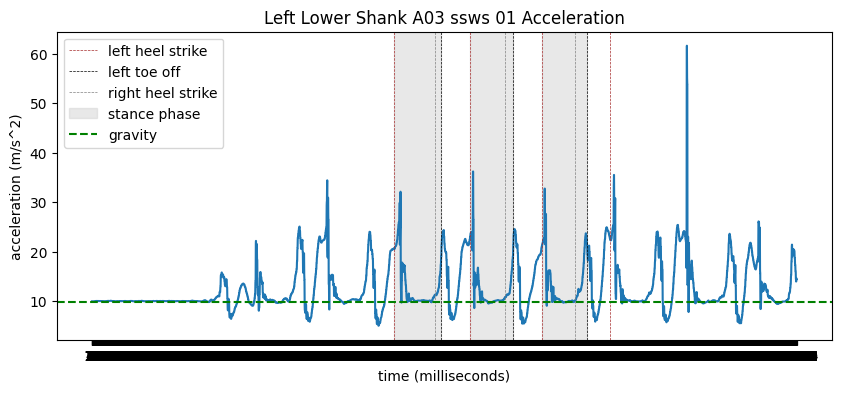

In [ ]:
lstrikes = [5016, 6286, 7475, 8615]
ltoeoffs = [5800, 7006, 8232]
rstrikes = [5697, 6867, 8036]
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.set_title(f'{imuexample.name} Acceleration')
ax.set_xlabel('time (milliseconds)')
ax.set_ylabel('acceleration (m/s^2)')
ax.plot(imuexample.net_acc*9.80665)
for i, strike in enumerate(lstrikes):
    ax.axvline(x=strike, color='brown', linestyle='--', linewidth=0.5, label='left heel strike' if i == 0 else '')
for i, to in enumerate(ltoeoffs):
    ax.axvline(x=to, color='black', linestyle='--', linewidth=0.5, label='left toe off' if i == 0 else '')
for i, strike in enumerate(rstrikes):
    ax.axvline(x=strike, color='grey', linestyle='--', linewidth=0.5, label='right heel strike' if i == 0 else '')
for i in range(3):
    ax.axvspan(lstrikes[i], ltoeoffs[i], color='lightgrey', alpha=0.5, label='stance phase' if i==0 else '')
ax.axhline(y=9.80665, color='green', linestyle='--', label='gravity')
ax.legend()
plt.show()

Using ```KalmanFilter``` to set up a filter.

In [ ]:
accdata = np.array(imuexample.net_acc*9.80665)

def plot_filter(myQ, myP, myU, myR):
    filtereddata = []
    P=myP

    for z in accdata:
        x, P = kf.predict(x=10., P=P, u=myU, Q=myQ)
        x, P = kf.update(x=x, P=P, z=z, R=myR)
        filtereddata.append(x)

    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(111)
    ax.set_title(f'{imuexample.name} Acceleration')
    ax.set_xlabel('time (milliseconds)')
    ax.set_ylabel('acceleration (m/s^2)')
    ax.plot(imuexample.net_acc*9.80665, label = 'raw', color='black',
            linewidth=0.8)
    ax.plot(filtereddata, label = 'filtered', linewidth=0.8)
    for i, strike in enumerate(lstrikes):
        ax.axvline(x=strike, color='brown', linestyle='--', linewidth=0.5,
                   label='left heel strike' if i == 0 else '')
    for i, to in enumerate(ltoeoffs):
        ax.axvline(x=to, color='black', linestyle='--', linewidth=0.5,
                   label='left toe off' if i == 0 else '')
    for i, strike in enumerate(rstrikes):
        ax.axvline(x=strike, color='grey', linestyle='--', linewidth=0.5,
                   label='right heel strike' if i == 0 else '')
    for i in range(3):
        ax.axvspan(lstrikes[i], ltoeoffs[i], color='lightgrey', alpha=0.5,
                   label='stance phase' if i==0 else '')
    ax.axhline(y=9.80665, color='green', linestyle='--', label='gravity')
    ax.legend()
    plt.show()

Q_slider = FloatSlider(
    value=2.**2, min=0., max=50., step=0.01, description="Q")
P_slider = FloatSlider(
    value=3., min=0.01, max=50.0, step=0.01, description="P")
u_slider = FloatSlider(
    value=1., min=0., max=50.0, step=0.01, description="u")
R_slider = FloatSlider(
    value=3.5**2, min=0., max=50.0, step=0.1, description="R")

interact(plot_filter, myQ=Q_slider, myP=P_slider, myU=u_slider, myR=R_slider);

interactive(children=(FloatSlider(value=4.0, description='Q', max=50.0, step=0.01), FloatSlider(value=3.0, des…

# References

1. [Kalman and Baysian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) - Roger Labbe
2. "[Visualizing quaternions (4d numbers) with stereographic projection](https://www.youtube.com/watch?v=d4EgbgTm0Bg)", "[Visualizing quaternions (4d numbers) with stereographic projection](https://www.youtube.com/watch?v=zjMuIxRvygQ)", "[Visualizing Quaternions](https://eater.net/quaternions)" - Ben Eater and Grant Sanderson
3. [kalmanfilter.net](https://www.kalmanfilter.net/background.html) - Alex Becker

### Extra Bad Code

$$\mathbf H = \begin{bmatrix}\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\end{bmatrix},$$
such that
$$\text{the residual} = \begin{bmatrix}\text{acc}_\text{pitch} \\ \text{acc}_{roll} \\ \text{acc}_{yaw} \\ \omega_\text{pitch} \\ \omega_{roll} \\ \omega_{yaw}\end{bmatrix} - \left(\begin{bmatrix}\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\end{bmatrix}\begin{bmatrix}p_x \\ p_y \\ p_z \\ v_x \\ v_y \\ v_z \\ q_0 \\ q_1 \\ q_2 \\ q_3 \\ \omega_x \\ \omega_y \\ \omega_z\end{bmatrix}\right),$$
or, more succinctly,
$$\mathbf y = \mathbf z_k - \left(\begin{bmatrix}\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot \\ \cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot&\cdot\end{bmatrix}\mathbf x_k\right).$$ equals the residual.

#### my attempt

A simple kalman filter.

Parameters
-

measurments: numpy array
    Array of nx1 column vector measurments.

initial_state: numpy array
    predicted initial state as mx1 column vector.

trial: str
    trial number as string.
    
path: str
    directory path as string. If you have set it up, using
    adrien_c3d_folder() is reccomended.

Returns
-

df: dataframe
    dataframe containing trial data.

In [ ]:
def simplekalman(measurments, initial_state=0, initial_error_covariance=6,
                 state_transition=1.03, measurement_model=1, process_noise=0,
                 measurement_covariance=1):
    # set variables
    A = state_transition
    At = np.transpose(A)
    H = measurement_model
    Ht = np.transpose(H)
    Q = process_noise
    R = measurement_covariance
    x = initial_state
    P = initial_error_covariance

    filtered_data = []
    # kalman algorithm
    for z in measurments:
        xp = A * x                      # state prediction
        Pp = A * P * At + Q             # covariance prediction
        K = Pp * Ht / (H * Pp * Ht + R) # kalman gain
        x = xp + K * (z - H * xp)       # state update
        P = Pp - K * H * Pp             # covariance update
        filtered_data.append(x)
    return filtered_data

Using filterpy, it must first be installed.

#### Using FilteryPy

In [ ]:
!pip install filterpy

example of ```predict``` function.

In [ ]:
import filterpy.kalman as kf
x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print(f'{x:.3f}')

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print(f'{x:.3f} {P:.3f}')

11.000
11.364 4.455


In [ ]:
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """

    myfilter = kf.KalmanFilter(dim_x=2, dim_z=1)
    myfilter.x = np.array([x[0], x[1]]) # location and velocity
    myfilter.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    myfilter.H = np.array([[1., 0]])    # Measurement function
    myfilter.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        myfilter.P *= P                 # covariance matrix
    else:
        myfilter.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        myfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        myfilter.Q[:] = Q
    return myfilter

Setting filter values

In [ ]:
dt = .1
x = np.array([0., 0.])
kf_example = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

printing results

In [ ]:
kf_example

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x79c70f3f52d0>